## Assignment A2a: Signal Detection

Please follow the General Assignment Guidelines document on canvas under the Pages for completing this assignment.  When you have completed the assignment, please follow the Submission Instructions.

### Overview

This assignment focuses on detecting simple signals in noise.

### Readings

The following material provides both background and additional context.  It linked in the Canvas page for this assignment.

- Dusenbery, D. B. (1992). *Sensory Ecology*. Chapter 5 Signal Detection, sections 5-1 and 5-2.

### Learning objectives

- write code to generate random signals
- use vector operations and logical indexing to concisely express computational ideas
- measure different types of detection errors
- characterize different types of error profiles with ROC curves

***
## Exercises

In [1]:
# import necessary packages
import numpy as np
import math
from matplotlib import pyplot as plt

### 1. Generating signals with events and additive noise

### 1a. Randomly occurring events in Gaussian noise

Write a function `genwaveform(N=100, α=0.1, A=1, σ=1)` to generate a waveform that is a linear combination of a sparsely occurring events and additive Gaussian noise. Here, we assume the events are fixed amplitude impulses that occur within a single sample.  The observed waveform, therefore, is a linear combination of the Gaussian background noise and these discrete events.  The parameters specify the waveform length `N`, the event probability `α`, the event amplitude `A`, and noise standard deviation $\sigma$.  Assume the noise mean is zero.  The values listed are defaults.  The event probability specifies the probability of an event occurring within a sample.  Assume the events are independent.  The function should return a tuple of the resulting waveform and array of the event locations as indices.

Plot the generated waveform samples and display the location of the events with markers.

(Comment on terminology: The term "signal" can refer either to an individual event or the collection of events as a whole.  The waveform is the signal plus the noise.  Note that "signal" is sometimes used loosely to refer to the observed waveform, rather than the waveform without the noise.  This is because the signal itself cannot be observed directly, only inferred.  The term "underlying signal" is often used to emphasize the component of the waveform without the noise.)

In [2]:
def genwaveform(N:int=100, alpha:float=0.1, A:float=1, sigma:float=0.1):
    # first generate the events occuring
    E = np.random.binomial(1, alpha, N)
    
    # generate y-values based on events with noise and return
    return np.array([0 + np.random.normal(0, sigma) if e == 0 else A + np.random.normal(0, sigma) for e in E]), E

In [3]:
def plot_waveform(W:np.array, E:np.array=None):
    # generate time values
    T = np.array(range(0, len(W)))
    
    # isolate markers to mark sigmal
    if E is not None:
        # get indices of signal
        E_sig = [i for i in range(len(E)) if E[i] == 1]
        
        # plot markers
        plt.scatter(T[E_sig], W[E_sig], marker="v", color="r")
    
    # plot
    plt.plot(T, W)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Generated wave based on event probability")
    plt.show()

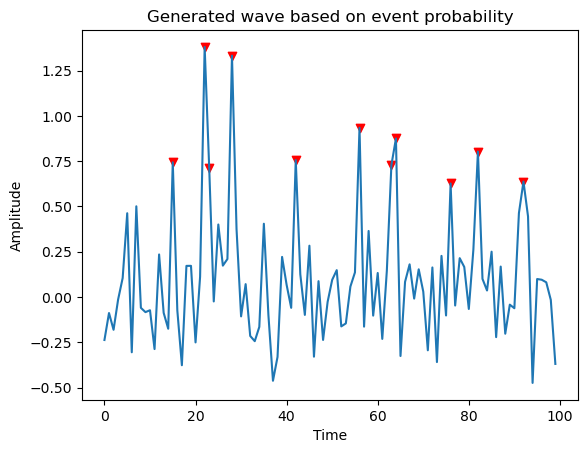

In [4]:
# test plot - if you pass the events, you also get markers where signal is
W, E = genwaveform(N=100, alpha=0.1, A=1, sigma=0.25)
plot_waveform(W, E)

### 1b. Signals in uniform noise

Modify the `genwaveform` function so that it accepts an argument `noisetype` to specify the type of noise.  Here we will use `Gaussian` and `uniform`.  For uniform noise, we again assume zero mean.  The $\sigma$ parameter should be interpreted as the width of the uniform distribution with range $[-\sigma/2, \sigma/2)$.

Plot an example using uniform noise.

In [5]:
def genwaveform(N:int=100, alpha:float=0.1, A:float=1, sigma:float=0.1, noisetype:str="gaussian"):
    # first generate the events occuring
    E = np.random.binomial(1, alpha, N)
    
    # generate y-values based on events with noise and return
    if noisetype == "uniform":
        return np.array([0 + np.random.uniform(-sigma/2, sigma/2) if e == 0 else A + np.random.uniform(-sigma/2, sigma/2) for e in E]), E
    else:
        return np.array([0 + np.random.normal(0, sigma) if e == 0 else A + np.random.normal(0, sigma) for e in E]), E

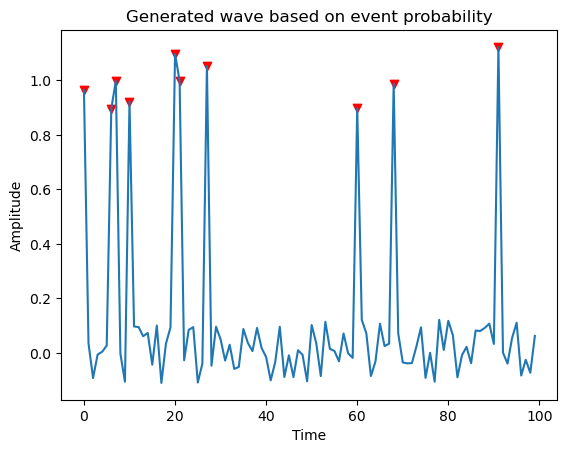

In [6]:
# test the new function with a noisetype = uniform
W, E = genwaveform(N=100, alpha=0.1, A=1, sigma=0.25, noisetype="uniform")
plot_waveform(W, E)

### 1c. Notation

For a discrete waveform, the observed sample at time t is $y[t]$. For additive noise, this is the sum of the signal $x[t]$ and the noise $\epsilon[t]$

$$
y[t] = x[t] + \epsilon[t]
$$
Note we have used square brackets to indicate that the functions are a discrete.

The discrete delta-function
$$
\delta[t] = \begin{cases}
1 & t = 0\\
0 & t \neq 0 \, ,
\end{cases}
$$
is commonly used is to express the occurrence of a unit impulse at sample $\tau$:
$$\delta[t-\tau]$$
i.e. a discrete function that is zero everywhere except at $t = \tau$, where it has a value of one.

Write an equation to express the signal $x[t]$ as a sum of $N$ events of amplitude $A$ that occur at times $\tau_i$.  Also write an expression to indicate that the noise $\epsilon[t]$ is distributed according to a Normal with mean $\mu$ and variance $\sigma^2$.

The equation to represent the signal $x[t]$ can be given as:
$$
x[t]=\sum_i^N A*\tau_i
$$
Additionally, the expression to indicate that noise is gaussian can be written as:
$$
\epsilon[t]=\frac{1}{\sqrt{2 \pi \sigma^2}}e^{-\frac{(x[t]-\mu)^{2}}{2\sigma^{2}}}
$$

### 1d. Conditional probability

What is the expression for the probability distribution of the waveform at time $t$ given that there is a signal?

Given that there is a signal at time $t$, the waveform at time $t$ can be expressed as the amplitude plus the error. Since we know that the error is gaussian noise, we can substitute the formula for gaussian noise here:
$$p(y(t)|signal)=A+\epsilon$$
$$p(y(t)|signal)=A+\frac{1}{\sqrt{2 \pi \sigma^2}}e^{-\frac{(x[t]-\mu)^{2}}{2\sigma^{2}}}$$

## 2. Signal detection

### 2a. Effect of parameters on detection probability

Explain what effect the parameters and type of noise have on detection probability.  For what values does the probability reduce to pure chance?  Or become certain (i.e. approach 1)?  Explain your reasoning and illustrate with plots.

There are two basic principles that tie into signal recognition. Firstly, the larger the amplitude relative to the baseline, the easier it is to separate what is the baseline from what is signal. Secondly, the standard deviation of the noise makes a big difference because the larger the standard deviation, the more difficult it will be to detect the signal compared to what is noise. See the plots below, which demonstrate these differences. Large $A$, small $A$, large $\sigma$, small $\sigma$. Notice that all of these parameters depend on how they are relative to the other, ie. how large the amplitude is relative to the standard deviation of noise.

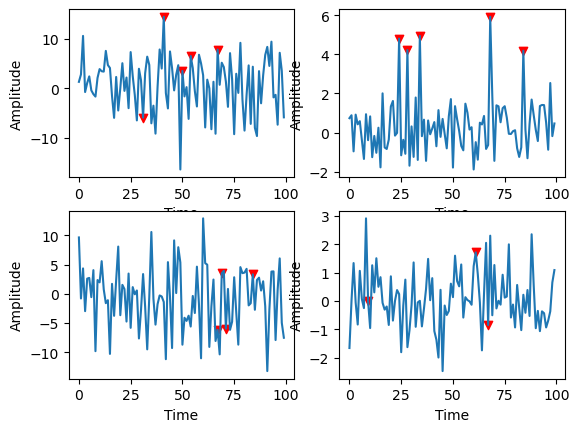

In [7]:
# define parameters
A = [5, 1]
S = [5, 1]

# generate plots with different parameters
fig, ax = plt.subplots(2, 2)

# loop to generate values and plot
for i in range(len(A)):
    for j in range(len(S)):
        T = np.array(range(0, len(W)))
        W, E = genwaveform(N=100, A=A[i], sigma=S[j], alpha=0.05)
        E_sig = [i for i in range(len(E)) if E[i] == 1]
        ax[i,j].plot(T, W)
        ax[i,j].scatter(T[E_sig], W[E_sig], marker="v", color="r")

# set axes
for a in ax.flat:
    a.set(xlabel="Time", ylabel="Amplitude")

Notice that in only one of the plots above, the signal is fairly easy to distinguish from the noise. This is the ideal condition where signal amplitude is larger than sigma. The other plots contain suboptimal conditions: large amplitude, large sigma; small amplitude, large sigma; small amplitude, small sigma.

### 2b. Types of detections and detection errors

Write a function `detectioncounts(si, y, θ)` which given an array `y`, signal index `si`, and threshold `θ`, returns a named tuple (tp, fn, fp, tn) of the counts of the true positives, false negatives, false positives, and true negatives.

Write a function that plots the samples and threshold and shows the true positives, false negatives, and false positives with different markers.

In [8]:
def detectioncounts(Si:np.array, Y:np.array, threshold:float):
    # find indices where signal >= threshold
    Se = np.array([1 if y >= threshold else 0 for y in Y])
    
    # calculate tp, fn, fp, tn
    tp = np.sum(np.logical_and(Se == 1, Si == 1))
    fn = np.sum(np.logical_and(Se == 0, Si == 1))
    fp = np.sum(np.logical_and(Se == 1, Si == 0))
    tn = np.sum(np.logical_and(Se == 0, Si == 0))
    
    # return
    return (tp, fn, fp, tn)

In [9]:
def plot_detectioncounts(Si:np.array, Y:np.array, threshold:float=0.8):
    # generate x-values
    T = np.array(range(0, len(Y)))
    
    # plot the easy stuff (Y and threshold)
    plt.plot(T, Y, label="waveform")
    plt.plot(T, [threshold for i in range(len(Y))], label="threshold")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Threshold-based Signal Detection")
    
    # find indices of tp, fp, fn
    Se = np.array([1 if y >= threshold else 0 for y in Y])
    tp = [i for i in range(len(Y)) if Se[i] == 1 and Si[i] == 1]
    fp = [i for i in range(len(Y)) if Se[i] == 1 and Si[i] == 0]
    fn = [i for i in range(len(Y)) if Se[i] == 0 and Si[i] == 1]
    
    # plot tp, fp, fn
    plt.scatter(T[tp], Y[tp], marker="v", color="red", label="true positive")
    plt.scatter(T[fp], Y[fp], marker="^", color="green", label="false positive")
    plt.scatter(T[fn], Y[fn], marker="o", color="blue", label="false negative")
    
    # add legend
    plt.legend()
    
    plt.show()

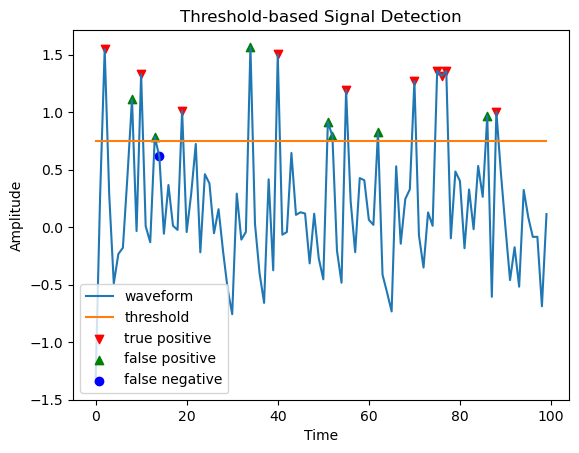

In [10]:
W, E = genwaveform(sigma=0.5)
plot_detectioncounts(Si=E, Y=W, threshold=0.75)

### 2c. Detection probabilities

Using either the error or signal probability distributions, what is the mathematical expression for the probability a false positive?  What is it for a false negative?  (Note that these are conditioned on the signal being absent or present, respectively.)
$$p(\text{false positive})=p(\text{signal detected}|\text{signal absent})=1-\int_\theta^\infty \frac{1}{\sqrt{2 \pi \sigma^2}}e^{-\frac{(x[t]-\mu)^{2}}{2\sigma^{2}}}dy=1-\frac{1}{2}[1+\text{erf}(\frac{\theta-\mu}{\sigma\sqrt{2}})]$$
$$p(\text{false negative})=p(\text{signal missed}|\text{signal present})=\int_{\theta}^{\infty}\frac{1}{\sqrt{2 \pi \sigma^2}}e^{-\frac{(y-A)^{2}}{2\sigma^{2}}}dy=1-\frac{1}{2}[1+\text{erf}(\frac{\theta-A}{\sigma\sqrt{2}})]$$ 

Write the functions `falsepos` and `falseneg` to return the expected false positive and negative rates.  The first argument should be the threshold $\theta$, the rest of the arguments should be keyword arguments that follow those of `genwaveform` but without unnecessary parameters.

In [11]:
def falsepos(threshold:float=1.0, sigma:float=0.1):
    return 1 - 0.5*(1+math.erf(threshold/(sigma*math.sqrt(2))))
    
def falseneg(threshold:float=1.0, sigma:float=0.1, A:float=1.0):
    return 0.5*(1+math.erf((threshold-A)/(sigma*math.sqrt(2))))

What are the expected error probabilities using the information and count results from above?  How could you estimate these from the distribution parameters and detection threshold?  Show that your empirical results are consistent with those calculated analytically.<br><br>
To test the results of my functions, we can compare the estimates from these functions to a real waveform that is generated. In order for us to be confident in the probabilistic estimate, our real example should be close to what is estimated by probability. We can see the results below:

In [12]:
# first generate a waveform and get the fp and fn rates
W, E = genwaveform(N=100000, sigma=2.0)
tp, fn, fp, tn = detectioncounts(E, W, 0.8)
fpr = fp/(fp+tn)
fnr = fn/(tp+fn)

# print the comparisons
print(f"probabilistic fnr: {falseneg(threshold=0.8, sigma=2.0, A=1)}")
print(f"tested fnr:        {fnr}")
print(f"probabilistic fpr: {falsepos(threshold=0.8, sigma=2.0)}")
print(f"tested fpr:        {fpr}")

probabilistic fnr: 0.460172162722971
tested fnr:        0.46418567426970786
probabilistic fpr: 0.3445782583896758
tested fpr:        0.34326252166570376


As can be seen from the tests above, the probabilistic and tested fnr and fpr are withing 1% of each other, suggesting they are good estimates for the true values generated.

## 3. ROC cures

### 3a. Threshold considerations

Explain why, in general, there is not an optimal value for the threshold.  What value minimizes the total error probability?  How is that different from minimizing the total number of errors?<br><br>
Optimal suggests there is a specific value at which the error is minimized. This is not the case for signal detection because there will always be some values which are detected while others are not. In some cases signal should not be detected. There is always a trade off between error rates.<br><br>
Minimizing the total error probability means that the threshold value should minimize the false negative and false positive rates collectively.<br><br>
The probability of error and the number of errors are fundamentelly different, but are both affected by the threshold in their own ways.

### 3b. ROC plot

Write a function `plotROC` to plot the ROC curve using the functions above.  It should use a similar parameter convention.

In [13]:
def plotROC(threshold_min:int=-5, threshold_max:int=5, alpha:float=1.0, sigma:float=1.0, A:float=1.0):
    # create array of thresholds
    T = np.linspace(threshold_min, threshold_max, 10*(threshold_max-threshold_min)+1)

    # calc FP and TP
    FP = np.array([falsepos(t, sigma) for t in T])
    TP = np.array([1-falseneg(t, A, sigma) for t in T])

    # calc min errors
    min_index = np.argmin((1-alpha) * FP + alpha * (1-TP))

    # plot the ROC curve
    plt.plot(FP, TP)
    plt.scatter(FP[min_index], TP[min_index], marker='v')
    plt.annotate(text=f"$\Theta$={round(T[min_index], 3)} - minimum error", xy=(FP[min_index]+0.05, TP[min_index]))
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

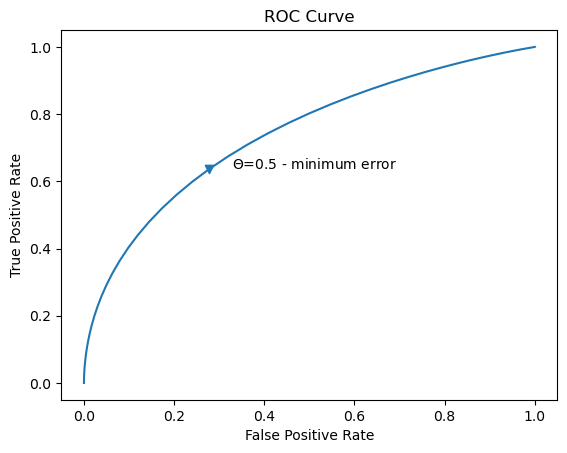

In [14]:
plotROC(-5, 5, 0.5, 0.85, 1)

### Tests and self checks

You should write tests for your code and make plots to verify that your implementations are correct.  After you submit your draft version, take the self check quiz.  This will give you feedback so you can make corrections and revisions before you submit your final version.  Here are examples of the types of questions you can expect

- conceptual questions from the readings and lectures
- questions from the assignment
- plot waveforms of signals in Gaussian and uniform noise using specified parameters
- plot examples that have high and low SNR
- question that use reference data ("A2a-testdata.h5" in "Files/assignment files" on Canvas)

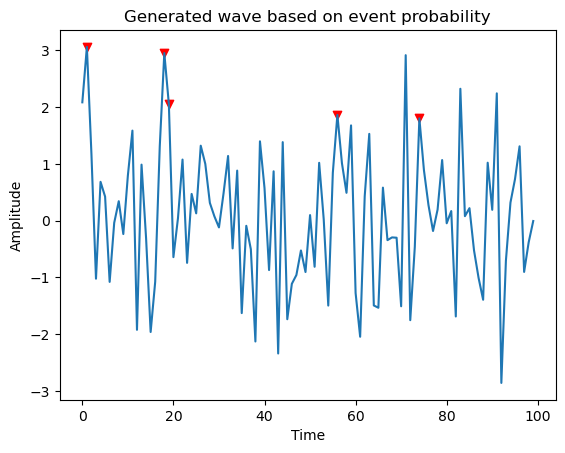

In [15]:
# Question 5
W, E = genwaveform(N=100, alpha=0.05, A=2, sigma=1, noisetype="Gaussian")
plot_waveform(W, E)

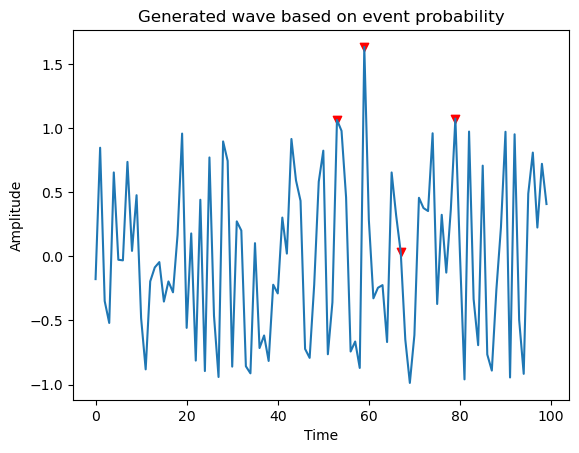

In [16]:
# Question 6
W, E = genwaveform(N=100, alpha=0.05, A=1, sigma=2, noisetype="uniform")
plot_waveform(W, E)

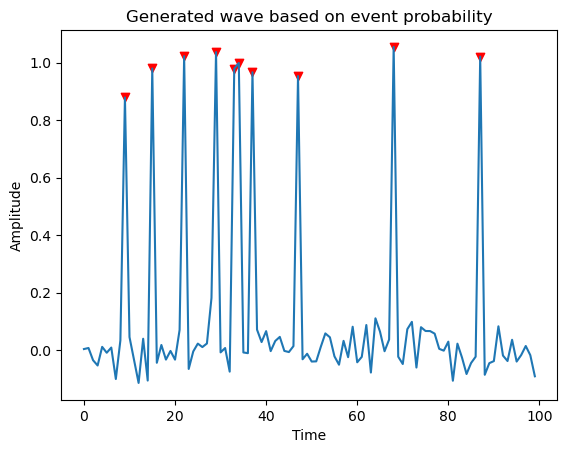

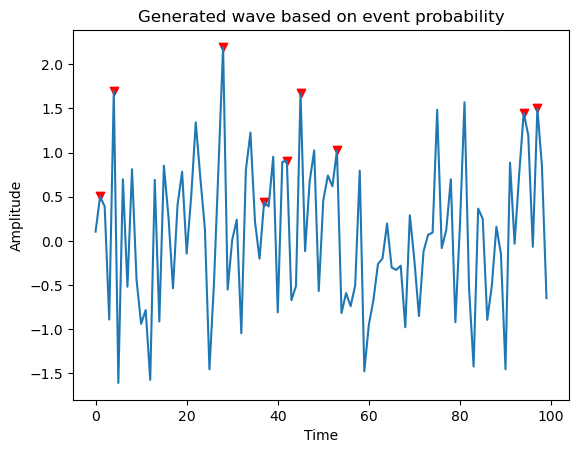

In [17]:
# Question 8 - high and low SNR
W, E = genwaveform(N=100, alpha=0.1, A=1, sigma=0.05, noisetype="Gaussian")
plot_waveform(W, E) # <- High SNR

W, E = genwaveform(N=100, alpha=0.1, A=1, sigma=0.75, noisetype="Gaussian")
plot_waveform(W, E)

In [18]:
# Question 12 - probability of false positive
falsepos(threshold=2, sigma=1)

0.02275013194817921

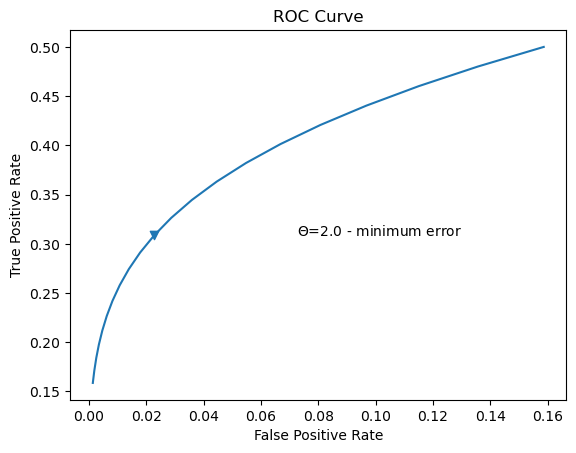

In [19]:
# Question 13 - threshold to minimize errors
plotROC(threshold_min=1, threshold_max=3, alpha=0.25, A=2, sigma=1)

In [20]:
# Question 6 - hdf5 and falsepositive/negatives
import h5py

In [21]:
file = h5py.File("A2a-testdata.h5", "r")
file["testdata"].keys()

<KeysViewHDF5 ['i250', 'i50', 'y250', 'y50']>

In [22]:
i50 = file["testdata"]["i50"][()]
y50 = file["testdata"]["y50"][()]
print(i50)
print(y50)

[ 3 17 20 26 28 34]
[-0.85005567  1.12940944 -1.34853346  3.2402909  -0.05564709  0.75939021
 -0.03026689 -0.36108267 -2.0073032  -0.56885913 -1.14962752  1.88062217
 -1.47062454 -0.53521097 -0.96354396 -1.38510807  0.13430024  1.38388333
 -1.71998936  0.32076928  0.5526271  -0.49227119 -0.41308738  1.00192851
  1.17468133 -1.32697035  0.40678513 -0.43870998  3.2257975  -1.44519085
  0.84177987  1.48909028  2.15943319 -0.90947902  3.1478203  -0.5050722
 -0.26706704  1.49908239  0.79730416 -0.17164044 -0.46907961  0.21762402
  0.35914641  0.32002472  0.25921633  0.45969599  0.20998636  1.52317539
  1.2597946  -0.1652831 ]


In [25]:
i50_mod = np.array([1 if i in i50 else 0 for i in range(len(y50))])

[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[-0.85005567  1.12940944 -1.34853346  3.2402909  -0.05564709  0.75939021
 -0.03026689 -0.36108267 -2.0073032  -0.56885913 -1.14962752  1.88062217
 -1.47062454 -0.53521097 -0.96354396 -1.38510807  0.13430024  1.38388333
 -1.71998936  0.32076928  0.5526271  -0.49227119 -0.41308738  1.00192851
  1.17468133 -1.32697035  0.40678513 -0.43870998  3.2257975  -1.44519085
  0.84177987  1.48909028  2.15943319 -0.90947902  3.1478203  -0.5050722
 -0.26706704  1.49908239  0.79730416 -0.17164044 -0.46907961  0.21762402
  0.35914641  0.32002472  0.25921633  0.45969599  0.20998636  1.52317539
  1.2597946  -0.1652831 ]


In [24]:
tp, fn, fp, tn = detectioncounts(i50_mod, y50, 1)
print(f"false positives: {fp}")

false positives: 9


***
### Submission Instructions

Please refer to the Assignment Submission Instructions on canvas under the Pages tab.